<a href="https://colab.research.google.com/github/glaria/data_analysis_big_data/blob/main/spark_sql_rdd_graphframes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png)  ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png)
# PEC 4

Ex. created by: Joan Tomas Matamalas Llodra jtmatamalas@uoc.edu

## Knowledge extraction from heterogeneous data sources using Spark SQL, RDDs and GraphFrames

- **Part 0:** Environment setup
- **Part 1:** Introduction to structured data frames and how to operate extract information 
    - **Part 1.1:** Import the data 
    - **Part 1.2:** *Queries* about complex data frames 
        - **Part 1.2.1:** SQL Queries 
        - **Part 1.2.2:** Queries about the pipeline 
- **Part 2:** HIVE databases and complex operations 
    - **Part 2.1:** Hive databases
    - **Part 2.2:** Beyond SQL Transformations 
        - **Part 2.2.1:** Tweets per population 
            - **Part 2.2.1.1:** Using SQL 
            - **Part 2.2.1.2:** Using RDD 
        - **Part 2.2.2:** Count hashtags 
- **Part 3:** Sampling 
    - **Part 3.1:** Homogeneous 
    - **Part 3.2:** Stratified 
- **Part 4**: Introduction to relational data 
    - **Part 4.1:** Generate the retweet network 
        - **Part 4.1.1**: Construction of the edgelist 
        - **Part 4.1.2**: Degree centrality 
    - **Part 4.2:** Network analysis using GraphFrames 
        - **Part 4.2.1:** Create a graph frame 
        - **Part 4.2.2:** PageRank Centrality 

## **Part 0:** Environment setup

In [ ]:
import findspark
findspark.init()

In [ ]:
import re
import os
import pandas as pd
from matplotlib import pyplot as plt
from math import floor
from pyspark import SparkConf, SparkContext, SQLContext, HiveContext
from pyspark.sql import Row

In [ ]:
SUBMIT_ARGS = "--packages graphframes:graphframes:0.7.0-spark2.4-s_2.11 pyspark-shell"
os.environ["PYSPARK_SUBMIT_ARGS"] = SUBMIT_ARGS

conf = SparkConf()
conf.setMaster("local[1]")
# Introducid el nombre de la app PEC3_ seguido de vuestro nombre de usuario
conf.setAppName("PAC3_lglaria")
sc = SparkContext(conf=conf)

## **Part 1:** Introduction to structured data frames and operations on them.

As already mentioned, in this practice we are going to use Twitter data that we collected during the general elections in Spain on April 28, 2019. As we will see, the tweets have a rather complex internal structure that we have simplified a bit in this practice.

### **Part 1.1:** Import the data

The first thing we are going to learn is how to import this type of data into our environment. One of the most common types of files to store this information format is [the JSON structure] (https://en.wikipedia.org/wiki/JSON). This structure allows information to be saved in a plain text of different objects following a dictionary structure where each field is assigned a key and a value. The structure can be nested, that is, a key can have another dictionary-type structure as its value.

Spark SQL allows you to read data from many different formats (as you will remember from the previous practice where we read a CSV file). This time, you are asked to read a JSON file from the path ```/aula_M2.858/data/tweets28a_sample.json```. This file contains a small *sample*, 0.1% of the complete database (in a next section we will see how to perform this *sampling*). This time you are not asked to specify the structure of the data frame since the read function will infer it automatically.

In [ ]:
sqlContext = SQLContext(sc)
tweets_sample = sqlContext.read.json("/aula_M2.858/data/tweets28a_sample.json")

print("Loaded dataset contains %d tweets" % tweets_sample.count())

Loaded dataset contains 27268 tweets


The next step is to show the structure of the dataset that we just loaded. 

---

Remember that you can get the information about how the DataTable is structured using the method ``` printSchema ()```.

In [ ]:
tweets_sample.printSchema()

root
 |-- _id: string (nullable = true)
 |-- created_at: long (nullable = true)
 |-- lang: string (nullable = true)
 |-- place: struct (nullable = true)
 |    |-- bounding_box: struct (nullable = true)
 |    |    |-- coordinates: array (nullable = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: double (containsNull = true)
 |    |    |-- type: string (nullable = true)
 |    |-- country_code: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- place_type: string (nullable = true)
 |-- retweeted_status: struct (nullable = true)
 |    |-- _id: string (nullable = true)
 |    |-- user: struct (nullable = true)
 |    |    |-- followers_count: long (nullable = true)
 |    |    |-- friends_count: long (nullable = true)
 |    |    |-- id_str: string (nullable = true)
 |    |    |-- lang: string (nullable = true)
 |    

You can see that the tweet structure contains multiple nested fields. You have to familiarize yourself with this structure since it will be the one that we will use throughout the practice. Remember also that not all tweets have all fields, such as location (field ```place```). When this happens the field becomes ```NULL```. You can see more information about this type of data in [this link] (https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object).

### **Part 1.2:** *Queries* about complex data frames

In the previous practice we have seen how to query a very simple dataset using *SQL* statements. In this part we are going to refresh the concepts used in the previous practice by introducing some more advanced concepts and a new way of working on data tables.

#### **Part 1.2.1:** SQL Queries

As you will remember from part 3 of the previous PEC, the first step is to register the table in the SQL context, first checking if it exists and deleting it if it does. In this section you are asked to register the table ```tweets_sample``` that we just loaded in the sql context under the same name``` tweets_sample```.

In [ ]:
sqlContext.sql("DROP TABLE IF EXISTS tweets_sample")
sqlContext.registerDataFrameAsTable(tweets_sample,"tweets_sample")

Now you are asked to create a table ```users_agg``` with [the added information] (https://www.w3schools.com/sql/sql_groupby.asp) of the users who have their language defined (``` user.lang```) as Spanish (```es```). Specifically, you are asked that the table contain the following columns:
- **screen_name:** username
- **friends_count:** maximum number (see note) of people you follow
- **tweets:** number of tweets made
- **followers_count:** maximum number (see note) people who follow the user.

The order in which the records should be displayed is descending order according to the number of tweets.

***Note:*** It is important that you pay attention that the name of *friends* and *followers* may differ throughout the data acquisition. In this case we are going to use the aggregation function ```MAX``` on each of these fields to avoid segmenting the user in different instances.

In [ ]:
users_agg = sqlContext.sql("SELECT user.screen_name,COUNT(*) as tweets, MAX(user.friends_count)as friends_count, MAX(user.followers_count) as followers_count FROM tweets_sample WHERE user.lang = 'es' GROUP BY  user.screen_name ORDER BY COUNT(*) DESC")
users_agg.limit(100).show()

+---------------+------+-------------+---------------+
|    screen_name|tweets|friends_count|followers_count|
+---------------+------+-------------+---------------+
|       anaoromi|    16|         6258|           6774|
|    RosaMar6254|    14|         6208|           6245|
|        lyuva26|    13|         3088|           3732|
|PisandoFuerte10|    12|         2795|           1752|
|     carrasquem|    12|          147|            215|
|       jasalo54|    11|         1889|            689|
|  PabloChabolas|     9|         4925|           4042|
|      lolalailo|     9|         4922|           3738|
|     Lordcrow11|     9|         5002|           3069|
|    DuroBelinda|     9|         5242|           5778|
| locuspolitikus|     9|        11261|          10244|
|      kikyosanz|     9|          154|            273|
|  Rafa_eltorete|     9|          908|           1060|
|   rosavergar23|     8|          900|           1224|
|        Fermirv|     8|         3031|           1731|
|       Li

In [ ]:
output = users_agg.first()
assert output.screen_name == 'anaoromi' and output.friends_count == 6258 and output.tweets == 16 and output.followers_count == 6774, "Incorrect output"

Now imagine that we want to combine the information we just generated with information about the number of times a user has been retweeted. To do this type of combination we need to resort to the [```JOIN``` of tables] (https://www.w3schools.com/sql/sql_join.asp). We must first register the table we just generated in the SQL context. Remember that you must first check if the table exists and if so, delete it. You have to register the table under the name of ```user_agg```.

In [ ]:
sqlContext.sql("DROP TABLE IF EXISTS users_agg")
sqlContext.registerDataFrameAsTable(users_agg,"users_agg")

Once registered, you are asked to combine this table and the table ```tweets_sample``` using an ```INNER JOIN``` to obtain a new table with the following information:
- ***screen_name:*** username
- ***friends_count:*** maximum number of people you follow
- ***followers_count:*** maximum number of people who follow the user.
- ***tweets:*** number of tweets made by the user.
- ***retweeted:*** number of retweets obtained by the user.
- ***ratio_tweet_retweeted:*** ratio of retweets by number of tweets published $\frac {retweets} {tweets} $

In [ ]:
retweeted = sqlContext.sql(""" SELECT a.screen_name
                                , a.friends_count
                                , a.followers_count
                                , a.tweets
                                , COUNT(b.retweeted_status) as retweeted
                                , COUNT(b.retweeted_status)/a.tweets as ratio_tweet_retweeted
                               FROM users_agg a INNER JOIN tweets_sample b on a.screen_name = b.retweeted_status.user.screen_name
                               GROUP BY a.screen_name, a.friends_count
                                , a.followers_count
                                , a.tweets
                                ORDER BY COUNT(b.retweeted_status) DESC
                            """)
                           

retweeted.limit(10).show()

+--------------+-------------+---------------+------+---------+---------------------+
|   screen_name|friends_count|followers_count|tweets|retweeted|ratio_tweet_retweeted|
+--------------+-------------+---------------+------+---------+---------------------+
|          PSOE|        13635|         671073|     1|      155|                155.0|
|  CiudadanosCs|        92910|         511896|     1|      117|                117.0|
|     JuntsXCat|          202|          88515|     1|       73|                 73.0|
|  PartidoPACMA|         1498|         232932|     1|       63|                 63.0|
|  pablocasado_|         4567|         238926|     1|       50|                 50.0|
|voxnoticias_es|         2146|          29582|     1|       44|                 44.0|
|RaiLopezCalvet|         7579|          13574|     1|       43|                 43.0|
|        iunida|        10225|         558318|     1|       39|                 39.0|
|        Xuxipc|          311|         184967|     1| 

In [ ]:
output = retweeted.first()
assert output.screen_name == 'PSOE' and output.friends_count == 13635 and output.tweets == 1 and output.followers_count == 671073 and output.ratio_tweet_retweeted == 155.0 and output.retweeted == 155, "Incorrect output"

#### **Part 1.2.2:** Queries through the pipeline

Spark SQL tables provide another mechanism to apply transforms and obtain results similar to what you would get by applying an SQL query. For example, using the following pipeline we will obtain the text of all the tweets in Spanish:

```
tweets_sample.where ("lang == 'es'"). select ("text")
```

Which is equivalent to the following SQL statement:

```
SELECT text
FROM tweets_sample
WHERE lang == 'is'
```

You can consult the [Spark SQL API] (https://spark.apache.org/docs/latest/api/python/pyspark.sql.html) to find more information on how to use the different transformations in tables.

In this exercise you are asked to replicate the query obtained in the previous section, starting by generating the table ```users_agg```. You can use the transformations ```where```,``` select``` (or ```selectExpr```),``` groupBy```, ```count```,```agg ```and ```orderBy```

In [ ]:
import pyspark.sql.functions as f
users = tweets_sample.where( "user.lang = 'es'").select("user.screen_name","user.friends_count", "user.followers_count")
users_agg = users.groupBy("screen_name")\
                 .agg(f.count('*'), f.max("friends_count"), f.max("followers_count"))\
                 .orderBy("count(1)", ascending=0)

users_agg.limit(10).show()

+---------------+--------+------------------+--------------------+
|    screen_name|count(1)|max(friends_count)|max(followers_count)|
+---------------+--------+------------------+--------------------+
|       anaoromi|      16|              6258|                6774|
|    RosaMar6254|      14|              6208|                6245|
|        lyuva26|      13|              3088|                3732|
|PisandoFuerte10|      12|              2795|                1752|
|     carrasquem|      12|               147|                 215|
|       jasalo54|      11|              1889|                 689|
|  PabloChabolas|       9|              4925|                4042|
|      lolalailo|       9|              4922|                3738|
|     Lordcrow11|       9|              5002|                3069|
|    DuroBelinda|       9|              5242|                5778|
+---------------+--------+------------------+--------------------+



If you look you will see that the name of the columns does not correspond to the one obtained previously, you can change the name of a specific column using the transformation ```withColumnRenamed```. Rename the columns to match the previous section and save them in a ```user_agg_new``` variable.

In [ ]:
users_agg_new = users_agg.withColumnRenamed("count(1)", "tweets")\
                         .withColumnRenamed("max(friends_count)","friends_count")\
                         .withColumnRenamed("max(followers_count)","followers_count")

users_agg_new.limit(10).show()

+---------------+------+-------------+---------------+
|    screen_name|tweets|friends_count|followers_count|
+---------------+------+-------------+---------------+
|       anaoromi|    16|         6258|           6774|
|    RosaMar6254|    14|         6208|           6245|
|        lyuva26|    13|         3088|           3732|
|PisandoFuerte10|    12|         2795|           1752|
|     carrasquem|    12|          147|            215|
|       jasalo54|    11|         1889|            689|
|  PabloChabolas|     9|         4925|           4042|
|      lolalailo|     9|         4922|           3738|
|     Lordcrow11|     9|         5002|           3069|
|    DuroBelinda|     9|         5242|           5778|
+---------------+------+-------------+---------------+



In [ ]:
output = users_agg_new.first()
assert output.screen_name == 'anaoromi' and output.friends_count == 6258 and output.tweets == 16 and output.followers_count == 6774, "Incorrect output"


Now create a table ```user_retweets``` using transformations that contains two columns:
- ***screen_name:*** username
- ***retweeted:*** number of retweets

You can use the same transformations as in the previous exercise. Sort the table in descending order using the value of the column ```retweeted```.

In [ ]:
user_retweets = tweets_sample.where("retweeted_status.user.statuses_count > '0'").select("retweeted_status.user.screen_name")
user_retweets = user_retweets.groupBy("screen_name")\
                 .agg(f.count('*'))\
                 .orderBy("count(1)", ascending=0)
user_retweets = user_retweets.withColumnRenamed("count(1)", "retweeted")
user_retweets.limit(10).show()

+--------------+---------+
|   screen_name|retweeted|
+--------------+---------+
|        vox_es|      299|
|  ahorapodemos|      238|
| Santi_ABASCAL|      238|
|      iescolar|      166|
| AlbanoDante76|      161|
|          PSOE|      155|
|AntonioMaestre|      154|
|          KRLS|      149|
|        boye_g|      142|
|  CiudadanosCs|      117|
+--------------+---------+



In [ ]:
output = user_retweets.first()
assert output.screen_name == 'vox_es' and output.retweeted == 299, "Incorrect output"

Another way to join two tables is by using the [table method join] (https://spark.apache.org/docs/latest/api/python/pyspark.sql.html). Combine the information from table users_agg_new and user_retweets into a new table retweeted using columnscreen_name. Sort the new table in descending order with the name of retweets.



In [ ]:
retweeted = users_agg_new.join(user_retweets, users_agg_new.screen_name == user_retweets.screen_name)\
                         .orderBy(user_retweets.retweeted, ascending=0)

retweeted.limit(10).show()

+--------------+------+-------------+---------------+--------------+---------+
|   screen_name|tweets|friends_count|followers_count|   screen_name|retweeted|
+--------------+------+-------------+---------------+--------------+---------+
|          PSOE|     1|        13635|         671073|          PSOE|      155|
|  CiudadanosCs|     1|        92910|         511896|  CiudadanosCs|      117|
|     JuntsXCat|     1|          202|          88515|     JuntsXCat|       73|
|  PartidoPACMA|     1|         1498|         232932|  PartidoPACMA|       63|
|  pablocasado_|     1|         4567|         238926|  pablocasado_|       50|
|voxnoticias_es|     1|         2146|          29582|voxnoticias_es|       44|
|RaiLopezCalvet|     1|         7579|          13574|RaiLopezCalvet|       43|
|        iunida|     1|        10225|         558318|        iunida|       39|
|        Xuxipc|     1|          311|         184967|        Xuxipc|       37|
|       Panik81|     1|         1587|          15374

In [ ]:
output = retweeted.first()
assert output.screen_name == 'PSOE' and output.friends_count == 13635 and output.tweets == 1 and output.followers_count == 671073 and output.retweeted == 155, "Incorrect output"

You will notice that some of the records that appear in the ```users_retweeted``` table are not present in the retweeted table. This is because, by default, the method applies an inner join and therefore only combines the records present in both tables. You can change this behavior through the function parameters.

To finish this part and reconstruct the result of section 1.2.1 we are going to add a column ```ratio_tweet_retweeted``` with information on the ratio between retweets and tweets. For this you must use the transformation ```withColumn```. The result must be sorted considering this new column in descending order.

In [ ]:
retweeted = retweeted.withColumn('ratio_tweet_retweeted',retweeted.retweeted/retweeted.tweets)
retweeted = retweeted.orderBy(retweeted.ratio_tweet_retweeted, ascending=0)
retweeted.limit(10).show()

+--------------+------+-------------+---------------+--------------+---------+---------------------+
|   screen_name|tweets|friends_count|followers_count|   screen_name|retweeted|ratio_tweet_retweeted|
+--------------+------+-------------+---------------+--------------+---------+---------------------+
|          PSOE|     1|        13635|         671073|          PSOE|      155|                155.0|
|  CiudadanosCs|     1|        92910|         511896|  CiudadanosCs|      117|                117.0|
|     JuntsXCat|     1|          202|          88515|     JuntsXCat|       73|                 73.0|
|  PartidoPACMA|     1|         1498|         232932|  PartidoPACMA|       63|                 63.0|
|  pablocasado_|     1|         4567|         238926|  pablocasado_|       50|                 50.0|
|voxnoticias_es|     1|         2146|          29582|voxnoticias_es|       44|                 44.0|
|RaiLopezCalvet|     1|         7579|          13574|RaiLopezCalvet|       43|             

In [ ]:
output = retweeted.first()
assert output.screen_name == 'PSOE' and output.friends_count == 13635 and output.tweets == 1 and output.followers_count == 671073 and output.ratio_tweet_retweeted == 155.0 and output.retweeted == 155, "Incorrect output"

## **Part 2:** HIVE databases and complex operations

So far we have been working with a small sample of the generated tweets (0.1%). In this part of the PEC we are going to see how to work and deal with the complete dataset. For this we have to use both transformations on tables and operations on RDD when necessary.

### **Part 2.1:** Hive databases

Many times the data with which we are going to work will be used in various projects. One way to organize the data is, instead of using the files directly, to use a database to manage the information. In the Hadoop environment, one of the most used databases is [Apache Hive] (https://hive.apache.org/), a database that allows you to work with distributed content.

The way to access this database is by creating a Hive context in much the same way as we declare an SQL context. First of all we are going to declare a variable ```hiveContext``` by instantiating it as an object of class ```HiveContext```. Then we will check how many tables are registered in this context.

In [ ]:
hiveContext = HiveContext(sc)
hiveContext.tables().show()

+--------+-------------+-----------+
|database|    tableName|isTemporary|
+--------+-------------+-----------+
| default| province_28a|      false|
| default|    tweets28a|      false|
| default|    user_info|      false|
| default|user_info_old|      false|
|        |tweets_sample|       true|
|        |    users_agg|       true|
+--------+-------------+-----------+



Note that right now we have five tables recorded in this context. Three of them are not temporary and two are temporary, which we have previously registered. Therefore sqlContext and hiveContext are connected (it is the same session)

We are going to create a variable ```tweets``` that we will use to access the table ```tweets28a``` stored in ```hiveContext``` using the method ```table ()``` of This object.

In [ ]:
tweets = hiveContext.table('tweets28a')
print("Loaded dataset contains {} tweets".format(tweets.count()))

Loaded dataset contains 25419835 tweets


Using the same method as in section 1.1, check the structure of the table we just loaded.

In [ ]:
tweets.printSchema()

root
 |-- _id: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- lang: string (nullable = true)
 |-- place: struct (nullable = true)
 |    |-- bounding_box: struct (nullable = true)
 |    |    |-- coordinates: array (nullable = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: double (containsNull = true)
 |    |    |-- type: string (nullable = true)
 |    |-- country_code: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- place_type: string (nullable = true)
 |-- retweeted_status: struct (nullable = true)
 |    |-- _id: string (nullable = true)
 |    |-- user: struct (nullable = true)
 |    |    |-- followers_count: long (nullable = true)
 |    |    |-- friends_count: long (nullable = true)
 |    |    |-- id_str: string (nullable = true)
 |    |    |-- lang: string (nullable = true)
 

### **Parte 2.2:** Más allá de las transformaciones SQL

Algunas veces vamos a necesitar obtener resultados que precisan operaciones que van más allá de lo que podemos conseguir utilizando el lenguaje SQL. En esta parte de la práctica vamos practicar cómo pasar de una tabla a un RDD, para hacer operaciones complejas, y luego volver a pasar a una tabla.

#### **Parte 2.2.1:** Tweets por población
##### **Parte 2.2.1.1:** Utilizando SQL
Un pequeño porcentaje, alrededor del 1%, de los tweets realizados está geolocalizado. Eso quiere decir que para estos tweets tenemos información acerca del lugar donde han sido realizados guardado en el campo ```place```. En este ejercicio se pide que utilizando una sentencia SQL mostréis en orden descendente cuántos tweets se han realizado en cada lugar. La tabla resultante ```tweets_place``` debe tener las siguientes columnas:
- ***name:*** nombre del lugar
- ***tweets:*** número de tweets

Recordad que no todos los tweets en la base de datos tienen que tener información geolocalizada, tenéis que filtrarlos teniendo en cuenta todos los que tienen un valor no nulo.

In [ ]:
hiveContext.sql("DROP TABLE IF EXISTS tweets")
hiveContext.registerDataFrameAsTable(tweets,"tweets")
tweets_place = hiveContext.sql("SELECT place.name, COUNT(*) AS tweets FROM tweets WHERE place.name is not NULL GROUP BY place.name ORDER BY COUNT(*) DESC")
tweets_place.limit(10).show()

+-----------+------+
|       name|tweets|
+-----------+------+
|     Madrid| 19655|
|  Barcelona| 13987|
|    Sevilla|  3820|
|   Valencia|  2833|
|   Zaragoza|  2449|
|Villamartín|  2364|
|     Málaga|  2184|
|     Murcia|  1800|
|    Granada|  1637|
|   Alicante|  1628|
+-----------+------+



In [ ]:
output = tweets_place.first()
assert output.name == "Madrid" and output.tweets == 19655, "Incorrect output"

##### **Parte 2.2.1.2:** Utilizando RDD

Ahora se os pide que hagáis lo mismo pero esta vez utilizando RDD para realizar la agregación (recordad los ejercicios de contar palabras que hicisteis en la PEC 1).

El primer paso consiste en generar un tabla ```tweets_geo``` que solo contenga información de tweets geolocalizados con una sola columna:
- ***name:*** nombre del lugar desde donde se ha generado el tweet

In [ ]:
tweets_geo = hiveContext.sql("SELECT place.name FROM tweets WHERE place.name is not NULL ")

Ahora viene la parte interesante. Una tabla puede convertirse en un RDD a través del atributo ```.rdd```. Este atributo guarda la información de la tabla en una lista donde cada elemento es un [objeto del tipo ```Row```](https://spark.apache.org/docs/1.1.1/api/python/pyspark.sql.Row-class.html). Los objetos pertenecientes a esta clase pueden verse como diccionarios donde la información de las diferentes columnas queda reflejada en forma de atributo. Por ejemplo, imaginad que tenemos una tabla con dos columnas, nombre y apellido, si utilizamos el atributo ```.rdd``` de dicha tabla obtendremos una lista con objetos del tipo row donde cada objeto tiene dos atributos: nombre y apellido. Para acceder a los atributos solo tenéis que utilizar la sintaxis *punto* de Python, e.g., ```row.nombre``` o ```row.apellido```.

En esta parte del ejercicio se os pide que creeis un objeto ```tweets_lang_rdd``` que contenga una lista de tuplas con la información ```(name, tweets)``` sobre el nombre del lugar y el número de tweets generados desde allí. Recordad el ejercicio de contar palabras de la PEC 1.

In [ ]:
tweets_place_rdd = tweets_geo.rdd.map(list).map(lambda x: x[0]).map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y)
tweets_place_rdd.take(20)


[('Altafulla', 49),
 ('Maryville', 1),
 ('Zamudio', 3),
 ('Aschaffenburg', 1),
 ('Summerlin South', 1),
 ('Sanxenxo', 23),
 ('San José Obrero', 1),
 ('Wiltz', 2),
 ('Santomera', 4),
 ('宇部市', 1),
 ('Alcalá de la Selva', 4),
 ('Greenville', 40),
 ('Erandio', 25),
 ('Platja de Gavà', 1),
 ('Boxmeer', 1),
 ('Valencina de la Concepción', 14),
 ('Vilallonga del Camp', 7),
 ('Escola Pública Ildefons Cerdà, Escola de Baix', 4),
 ('Panticosa', 2),
 ('Talca', 15)]

Una vez generado este RDD vamos a crear un tabla. El primer paso es generar por cada tupla un objeto Row que contenga un atributo ```name``` y un atributo ```tweets```. Ahora solo tenéis que aplicar el método ```toDF()``` para generar una tabla. Ordenad las filas de esta tabla por el número de tweets en orden descendente.

In [ ]:
tweets_place = tweets_place_rdd.map(lambda t: Row(name=t[0], tweets=t[1])).toDF().orderBy('tweets', ascending=False)

tweets_place.limit(10).show()

+-----------+------+
|       name|tweets|
+-----------+------+
|     Madrid| 19655|
|  Barcelona| 13987|
|    Sevilla|  3820|
|   Valencia|  2833|
|   Zaragoza|  2449|
|Villamartín|  2364|
|     Málaga|  2184|
|     Murcia|  1800|
|    Granada|  1637|
|   Alicante|  1628|
+-----------+------+



In [ ]:
output = tweets_place.first()
assert output.name == "Madrid" and output.tweets == 19655, "Incorrect output"

#### **Parte 2.2.2:** Contar hashtags

En el ejercicio anterior hemos visto cómo podemos generar la misma información haciendo una agregación mediante SQL o utilizando RDDs. Como seguro que habéis observado la semántica de la sentencia SQL es mucho más limpia para realizar esta tarea. Pero no todas las tareas que os vais a encontrar se pueden hacer mediante sentencias SQL. En este ejercicio vamos a ver un ejemplo.

El objetivo de este ejercicio es contar el número de veces que cada hashtag (palabras precedidas por un #) ha aparecido en el dataset. Para evitar la sobrerrepresentación debida a los retweets vamos a concentrarnos en solo aquellos tweets que no son retweets de ningún otro, o dicho de otra manera, en aquellos en los que el campo ```retweeted_status``` es nulo. Cread una variable ```non_retweets``` que contenga todos estos tweets.

In [ ]:

#.map(lambda s: s.replace("…","")).map(deEmojify)\
#.map(lambda s: re.sub('#',' #', s))
non_retweets = hiveContext.sql("SELECT text FROM tweets WHERE retweeted_status.user is null").rdd.map(list)\
                          .map(lambda x: x[0]).map(lambda s: re.sub('#',' #', s))\
                          .map(lambda x: x.split()).flatMap(lambda xs: [x for x in xs])
#non_retweets = tweets.where("retweeted_status.user.statuses_count == '0'").select("text")
non_retweets.take(10)

['@Pablo_Iglesias_',
 '@MiguelTheFaker',
 'Pablo',
 'ya',
 'verás',
 'como',
 'se',
 'entere',
 'más',
 'de']

Seguidamente vamos ha crear una variable ```hashtags``` que contenga una lista de tuplas con la información ```(hashtag, count)```. Para ello, cread un RDD que contenga una lista con el texto de todos los tweets. Una vez hecho este paso tenéis que extraer los hashtags (palabras precedidas por un #) y contarlos.

Recordad los conocimientos adquiridos en la PEC 1 y el anterior ejercicio, os serán de gran ayuda.

In [ ]:
hashtags = non_retweets.filter(lambda x: x.startswith('#')).map(lambda x: x.strip('.,:?|!;"-)"')).map(lambda x: re.sub(r'\W+', ' ',x)).map(lambda s: re.sub(' ','', s)).map(lambda s: s.strip()).map(lambda s: '#'+s).map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y)
hashtags.take(10)

[('#039', 139),
 ('#laEspañaquequiero', 2),
 ('#PucherazoNo', 1),
 ('#checknews', 1),
 ('#elizabethwarren', 6),
 ('#amrkplaying', 1),
 ('#BADAJOZ', 1),
 ('#ThisistheRealSpain', 1),
 ('#VotadInsensatos', 2),
 ('#ingresos', 4)]

Finalmente, se os pide que con el RDD obtenido generéis una tabla ```hashtagsTable``` compuesta de dos columnas:
- ***hashtag***
- ***num:*** número de veces que aparece cada hashtag.

Ordenadla en orden descendente por número de tweets.

In [ ]:
hashtagsTable = hashtags.map(lambda t: Row(hashtag=t[0], num=t[1])).toDF().orderBy('num', ascending=False)


hashtagsTable.limit(20).show()



+--------------------+------+
|             hashtag|   num|
+--------------------+------+
|                #28A|158018|
|   #ElDebateDecisivo|108514|
|     #ELDEBATEenRTVE| 94192|
|#EleccionesGenera...| 33809|
|     #EquiparacionYa| 30563|
|       #EleccionesL6| 30058|
|         #HazQuePase| 26512|
|   #DebateAtresmedia| 21849|
|         #DebateRTVE| 17704|
|#LaHistoriaLaEscr...| 16958|
|          #PorEspaña| 16166|
|           #DebatTV3| 14693|
|#EleccionesGenerales| 14439|
|                #28a| 14320|
|         #ILPJusapol| 13487|
|            #28Abril| 12839|
|         #EspañaViva| 12619|
|           #VotaPSOE| 12279|
|        #ValorSeguro| 11133|
|                #VOX| 10695|
+--------------------+------+



In [ ]:
output = hashtagsTable.first()
assert output.hashtag == "#28A" and output.num >= 158000, "Incorrect output"

## **Part 3:** Sampling

In many occasions, before launching expensive processes, it is a common practice to deal with a small set of data to investigate some properties or simply to debug our algorithms, this task is called sampling. In this part of the practice we are going to look at the two main sampling methods and how to use them.

### **Part 3.1:** Homogeneous

The first sampling that we are going to see is [the homogeneous] (https://en.wikipedia.org/wiki/Simple_random_sample). This sampling is enough to simply choose a fraction of the population by randomly selecting elements from it.

First of all, we are going to carry out a homogeneous sampling of 1% of the tweets generated in the electoral period without replacement. Save in a variable ```tweets_sample``` this sample using the method ``` sample``` described in the [pyspark SQL API] (https://spark.apache.org/docs/latest/api/python /pyspark.sql.html). The seed that you are going to use to initialize the random generator is 42.

In [ ]:
seed = 42
fraction = 0.01

tweets_sample = tweets.sample(fraction, seed)

print("Number of tweets sampled: {0}".format(tweets_sample.count()))

Number of tweets sampled: 254185


In [ ]:
assert tweets_sample.count() == 254185, "Incorrect output"

Una de las cosas que resulta interesante comprobar acerca de los patrones de uso de las redes sociales es el patrón de uso diario. En este caso nos interesa el número promedio de tweets que se genera cada hora del día. Para extraer esta información lo que haremos primero, será generar una tabla ```tweets_timestamp``` con la información:
- ***created_at***: timestamp de cuando se publicó el tweet.
- ***hour***: a que hora del dia corresponde.
- ***day***: Fecha en formato MM-dd-YY

La fecha que figura en la base de datos esta en la franja horaria GMT. El primer paso es pasar esta información al horario peninsular de España, podéis utilizar la función ```from_utc_timestamp``` para este fin. Así mismo, la función ```hour``` os servirá para extraer la hora del timestamp y la función ```date_format``` os permitirá generar la fecha.

In [ ]:
from pyspark.sql.functions import date_format, hour, from_utc_timestamp

sqlContext.sql("DROP TABLE IF EXISTS tweets_sample")
sqlContext.registerDataFrameAsTable(tweets_sample,"tweets_sample")

tweets_timestamp = sqlContext.sql(""" SELECT from_utc_timestamp(created_at, 'Europe/Madrid') as created_at
                         ,hour(created_at) as hour
                         ,date_format(created_at, 'MM-dd-YY') as day
                               FROM tweets_sample
                               """)


tweets_timestamp.limit(20).show()

+-------------------+----+--------+
|         created_at|hour|     day|
+-------------------+----+--------+
|2019-04-21 04:24:26|   2|04-21-19|
|2019-04-21 04:24:44|   2|04-21-19|
|2019-04-21 04:24:46|   2|04-21-19|
|2019-04-21 04:25:50|   2|04-21-19|
|2019-04-21 04:25:53|   2|04-21-19|
|2019-04-21 04:25:59|   2|04-21-19|
|2019-04-21 04:26:21|   2|04-21-19|
|2019-04-21 04:27:31|   2|04-21-19|
|2019-04-21 04:28:01|   2|04-21-19|
|2019-04-21 04:28:09|   2|04-21-19|
|2019-04-21 04:28:14|   2|04-21-19|
|2019-04-21 04:28:21|   2|04-21-19|
|2019-04-21 04:28:35|   2|04-21-19|
|2019-04-21 04:28:53|   2|04-21-19|
|2019-04-21 04:29:10|   2|04-21-19|
|2019-04-21 04:29:34|   2|04-21-19|
|2019-04-21 04:29:39|   2|04-21-19|
|2019-04-21 04:29:56|   2|04-21-19|
|2019-04-21 04:30:06|   2|04-21-19|
|2019-04-21 04:30:25|   2|04-21-19|
+-------------------+----+--------+



El paso siguiente es agregar estos datos por hora y día en una tabla ```tweets_hour_day```. Tenéis que crear una tabla ```tweets_hour``` con la información:
- ***hour:*** hora del dia
- ***day:*** fecha
- ***count:*** número de tweets generados

In [ ]:
sqlContext.sql("DROP TABLE IF EXISTS tweets_timestamp")
sqlContext.registerDataFrameAsTable(tweets_timestamp,"tweets_timestamp")
tweets_hour_day = sqlContext.sql(""" SELECT hour,day, COUNT(*) AS count
                               FROM tweets_timestamp
                               GROUP BY hour,day
                               """)

tweets_hour_day.limit(20).show()

+----+--------+-----+
|hour|     day|count|
+----+--------+-----+
|  18|04-13-19|  536|
|  11|04-17-19|  529|
|  10|04-28-19|  770|
|  23|04-23-19| 4893|
|  11|04-28-19|  954|
|   7|04-22-19|  184|
|  16|04-24-19| 1000|
|   5|04-28-19|   76|
|   6|04-29-19|  289|
|   4|04-17-19|   69|
|   5|04-27-19|   97|
|  10|04-14-19|  489|
|  23|04-26-19| 1118|
|   7|04-17-19|  275|
|  13|04-25-19|  697|
|  20|04-28-19| 1644|
|   0|04-23-19| 2789|
|   6|04-23-19|  226|
|   7|04-26-19|  355|
|   8|04-21-19|  261|
+----+--------+-----+



Por último solo nos queda hacer una agregación por hora para conseguir el promedio de tweets por hora. Tenéis que generar una tabla ```tweets_hour``` con la información:
- ***hour:*** Hora
- ***tweets:*** Promedio de tweets realizados

Recordad que estamos trabajando con un sample del 1% por tanto tenéis que corregir la columna ```tweets``` para que refleje el promedio que deberíamos esperar en el conjunto completo de tweets. La tabla tiene que estar ordenada en orden ascendente de hora.

In [ ]:
sqlContext.sql("DROP TABLE IF EXISTS tweets_hour_day")
sqlContext.registerDataFrameAsTable(tweets_hour_day,"tweets_hour_day")

tweets_hour = sqlContext.sql(""" SELECT hour, avg(count)*100 as tweets
                               FROM tweets_hour_day
                               GROUP BY hour
                               ORDER BY hour
                               """)

tweets_hour.limit(24).show()

+----+------------------+
|hour|            tweets|
+----+------------------+
|   0|105005.55555555556|
|   1|51766.666666666664|
|   2| 23115.78947368421|
|   3|13094.117647058823|
|   4| 9370.588235294117|
|   5|  8347.05882352941|
|   6|11666.666666666668|
|   7|25627.777777777777|
|   8|42523.529411764706|
|   9| 52111.11111111111|
|  10|58344.444444444445|
|  11|           61350.0|
|  12| 62188.88888888889|
|  13| 66077.77777777778|
|  14| 67855.55555555555|
|  15| 71494.44444444445|
|  16| 67794.44444444445|
|  17| 63538.88888888889|
|  18| 67555.55555555555|
|  19| 68211.11111111111|
+----+------------------+
only showing top 20 rows



Por último, tenéis que producir un gráfico de barras utilizando Pandas donde se muestre la información que acabáis de generar.

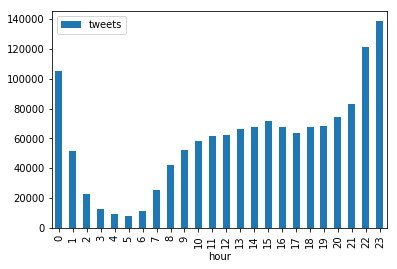

In [ ]:
tweets_hour_pd = tweets_hour.toPandas()
tweets_hour_pd.plot.bar(x='hour', y='tweets')


### **Parte 3.2:** Estratificado

In many cases, homogeneous sampling is not adequate since, due to the structure of the data, certain segments may be over-represented. This is the case that we observe in the tweets where large urban areas are overrepresented if we compare it with the volume of the population. In this activity we will see how to apply this technique to the tweet dataset, to obtain a sample that respects the proportion of deputies per province.

In Spain, the electoral process assigns a volume of deputies to each province that depends on the population and a minimum percentage assigned by law. In the Hive context that we have previously created (```hiveContext```) we can find a table (``` province_28a```) containing information about electoral districts. Load this table into a variable named ```province```.

In [ ]:
province = hiveContext.table('province_28a')
province.limit(20).show()

+-----------+-----------+------------------+----------+---------+
|    capital|   province|              ccaa|population|diputados|
+-----------+-----------+------------------+----------+---------+
|     Teruel|     Teruel|            Aragón|     35691|        3|
|      Soria|      Soria|   Castilla y León|     39112|        2|
|    Segovia|    Segovia|   Castilla y León|     51683|        3|
|     Huesca|     Huesca|            Aragón|     52463|        3|
|     Cuenca|     Cuenca|Castilla-La Mancha|     54898|        3|
|      Ávila|      Ávila|   Castilla y León|     57697|        3|
|     Zamora|     Zamora|   Castilla y León|     61827|        3|
|Ciudad Real|Ciudad Real|Castilla-La Mancha|     74743|        5|
|   Palencia|   Palencia|   Castilla y León|     78629|        3|
| Pontevedra| Pontevedra|           Galicia|     82802|        7|
|     Toledo|     Toledo|Castilla-La Mancha|     84282|        6|
|Guadalajara|Guadalajara|Castilla-La Mancha|     84910|        3|
|      Ceu

Para hacer un sampling estratificado lo primero que tenemos que hacer es determinar la fracción que queremos asignar a cada categoría. En este caso queremos una fracción que haga que el ratio tweets diputado sea igual para todas las capitales de provincia. Tenemos que tener en cuenta que la precisión de la geolocalización en Twitter és normalmente a nivel de ciudad. Por eso, para evitar incrementar la complejidad del ejercicio, vamos a utilizar los tweets en capitales de provincia como proxy de los tweets en toda la provincia.

Lo primero que tenéis que hacer es crear un tabla ```info_tweets_province``` que debe contener:
- ***capital:*** nombre de la capital de provincia.
- ***tweets:*** número de tweets geolocalizados en cada capital
- ***diputados:*** diputados que asignados a la provincia.
- ***ratio_tweets_diputado:*** número de tweets por diputado.

Debéis ordenar la lista por ```ratio_tweets_diputado``` en orden ascendente.

***Nota:*** Podéis realizar este ejercicio de muchas maneras, probablemente la más fácil es utilizar la tabla ```tweets_place``` que habéis generado en el apartado 2.2.1. Recordad cómo utilizar el ```join()```

In [ ]:
#<FILL IN>
sqlContext.sql("DROP TABLE IF EXISTS province")
sqlContext.registerDataFrameAsTable(province,"province")
sqlContext.sql("DROP TABLE IF EXISTS tweets_place")
sqlContext.registerDataFrameAsTable(tweets_place,"tweets_place") 
info_tweets_province = hiveContext.sql("""SELECT b.capital, a.tweets, b.diputados, a.tweets/b.diputados as ratio_tweets_diputado
                                    FROM tweets_place a
                                    INNER JOIN province b on a.name = b.capital
                                    ORDER BY  a.tweets/b.diputados
                                    """)


info_tweets_province.limit(20).show()

+--------------------+------+---------+---------------------+
|             capital|tweets|diputados|ratio_tweets_diputado|
+--------------------+------+---------+---------------------+
|              Teruel|    35|        3|   11.666666666666666|
|          Pontevedra|   154|        7|                 22.0|
|              Huesca|    85|        3|   28.333333333333332|
|              Zamora|    94|        3|   31.333333333333332|
|               Soria|    79|        2|                 39.5|
|             Segovia|   119|        3|   39.666666666666664|
|              Cuenca|   146|        3|   48.666666666666664|
|               Cádiz|   453|        9|   50.333333333333336|
|         Ciudad Real|   276|        5|                 55.2|
|            Pamplona|   281|        5|                 56.2|
|                Lugo|   229|        4|                57.25|
|Santa Cruz de Ten...|   471|        7|    67.28571428571429|
|                Jaén|   356|        5|                 71.2|
|       

In [ ]:
output = info_tweets_province.first()
maximum_ratio = floor(output.ratio_tweets_diputado * 100) / 100

assert output.capital == "Teruel" and output.tweets == 35 and output.diputados == 3 and maximum_ratio == 11.66, "Incorrect output"

Lo primero que vamos a necesitar es un diccionario con nombre ```ratios``` donde cada capital de provincia es una llave y su valor asociado es la fracción de tweets que vamos a samplear. En este caso lo que queremos es que el ratio de tweets por cada diputado sea similar para cada capital de provincia.

Como queremos que el sampling sea lo más grande posible y no queremos que ninguna capital este infrarepresentada el ratio de tweets por diputado será el valor más pequeño podéis observar en la tabla ```info_tweets_province```, que corresponde a 11.66 tweets por diputado en Teruel. Tenéis este valor guardado en la variable ```maximum_ratio```.

*Nota:* El método ```collectAsMap()``` transforma un PairRDD en un diccionario.

In [ ]:
#province > capital, maximum_ratio/diputados

sqlContext.sql("DROP TABLE IF EXISTS tweets_timestamp") #freeing memory
sqlContext.sql("DROP TABLE IF EXISTS info_tweets_province")
sqlContext.registerDataFrameAsTable(info_tweets_province,"info_tweets_province")
ratios = hiveContext.sql("SELECT DISTINCT capital, 11.6666666/ratio_tweets_diputado AS ratio_tweets_diputado FROM info_tweets_province").rdd.collectAsMap()
ratios

{'Albacete': 0.12578616280323449,
 'Alicante': 0.08599508550368551,
 'Almería': 0.13232514102079393,
 'Badajoz': 0.13725490117647057,
 'Barcelona': 0.02669145143347394,
 'Bilbao': 0.1078998067052023,
 'Burgos': 0.0895713366602687,
 'Castellón de la Plana': 0.11437908431372548,
 'Ceuta': 0.0804597696551724,
 'Ciudad Real': 0.2113526557971014,
 'Cuenca': 0.23972602602739726,
 'Cáceres': 0.1620370361111111,
 'Cádiz': 0.23178807814569533,
 'Córdoba': 0.0667938927480916,
 'Girona': 0.07314524514106582,
 'Granada': 0.0498880062309102,
 'Guadalajara': 0.13257575681818182,
 'Huelva': 0.09244585261489698,
 'Huesca': 0.41176470352941175,
 'Jaén': 0.1638576769662921,
 'Las Palmas de Gran Canaria': 0.0723514207751938,
 'León': 0.0846944943738657,
 'Lleida': 0.09079117976653696,
 'Logroño': 0.10727969287356322,
 'Lugo': 0.2037845694323144,
 'Madrid': 0.021962180829305518,
 'Melilla': 0.02615844529147982,
 'Murcia': 0.06481481444444444,
 'Málaga': 0.05876068342490842,
 'Oviedo': 0.06196256919575114,

Generad una tabla ```geo_tweets``` con los tweets geolocalizados.

In [ ]:
geo_tweets = hiveContext.sql("SELECT place.name, text FROM tweets WHERE place.name is not NULL")
#print((geo_tweets.count(), len(geo_tweets.columns)))


Ahora ya estamos en disposición de hacer el sampling estratificado por población. Para ello podéis utilizar el método ```sampleBy()```. Utilizad 42 como seed del generador pseudoaleatorio.

In [ ]:
seed = 42
sample = geo_tweets.sampleBy("name", fractions=ratios, seed=seed)
#print((sample.count(), len(sample.columns)))

Para visualizar el resultado del sampling vais a crear una tabla ```info_sample``` que contenga la siguiente información:
- ***capital:*** nombre de la capital de provincia.
- ***tweets:*** número de tweets sampleados en cada capital
- ***diputados:*** diputados que asignados a la provincia.
- ***ratio_tweets_diputado:*** número de tweets por diputado.

Ordenad la tabla resultante por orden de ```ratio_tweets_diputado```

In [ ]:
sqlContext.sql("DROP TABLE IF EXISTS sample")
sqlContext.registerDataFrameAsTable(sample,"sample")



#info_sample =  hiveContext.sql("SELECT COUNT(*), COUNT(DISTINCT capital) FROM info_tweets_province ")

info_sample =  hiveContext.sql("""SELECT DISTINCT capital,a.diputados, COUNT(*) as tweets, COUNT(*)/a.diputados AS ratio_tweets_diputado
                                  FROM info_tweets_province a
                                  INNER JOIN sample b on a.capital = b.name
                                  GROUP BY capital, diputados
                                  """).orderBy('ratio_tweets_diputado', ascending=True) 
#info_sample.printSchema()
info_sample.limit(20).show()

+---------------+---------+------+---------------------+
|        capital|diputados|tweets|ratio_tweets_diputado|
+---------------+---------+------+---------------------+
|        Melilla|        1|     6|                  6.0|
|          Ceuta|        1|     8|                  8.0|
|    Ciudad Real|        5|    44|                  8.8|
|           León|        4|    38|                  9.5|
|       Albacete|        4|    39|                 9.75|
|         Bilbao|        8|    80|                 10.0|
|         Zamora|        3|    30|                 10.0|
|    Guadalajara|        3|    30|                 10.0|
|       Palencia|        3|    30|                 10.0|
|       Alicante|       12|   122|   10.166666666666666|
|      Tarragona|        6|    62|   10.333333333333334|
|           Lugo|        4|    42|                 10.5|
|        Segovia|        3|    32|   10.666666666666666|
|         Toledo|        6|    64|   10.666666666666666|
|       Pamplona|        5|    

In [ ]:

output = info_sample.first()
assert output.capital == "Melilla" and output.tweets == 6 and output.diputados == 1 and output.ratio_tweets_diputado == 6.0, "Incorrect output"

Como veis el sampling no es exacto, es una aproximación. Pero como podéis imaginar acercar el sampling a la representatividad electoral de las regiones son necesarios en muchos análisis.

Para comprobarlo contad primero todos los hashtags presentes en la tabla ```geo_tweets``` tal como hemos hecho en el apartado 2.2.2 y ordenad el resultado por número de tweets en orden descendente

In [ ]:
geo_tweets_text = geo_tweets.select("text").rdd.map(list)\
                          .map(lambda x: x[0]).map(lambda s: re.sub('#',' #', s))\
                          .map(lambda x: x.split()).flatMap(lambda xs: [x for x in xs])
#non_retweets = tweets.where("retweeted_status.user.statuses_count == '0'").select("text")
#non_retweets.take(10)

hashtags_geo = geo_tweets_text.filter(lambda x: x.startswith('#')).map(lambda x: x.strip('.,:?|!;"-)"')).map(lambda x: re.sub(r'\W+', ' ',x)).map(lambda s: re.sub(' ','', s)).map(lambda s: s.strip()).map(lambda s: '#'+s).map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y)

hashtagsTable_geo = hashtags_geo.map(lambda t: Row(hashtag=t[0], num=t[1])).toDF().orderBy('num', ascending=False)


hashtagsTable_geo.limit(20).show()

+--------------------+----+
|             hashtag| num|
+--------------------+----+
|                #28A|7411|
|   #ElDebateDecisivo|3938|
|     #ELDEBATEenRTVE|3510|
|     #EquiparacionYa|2309|
|       #6AbrilMadrid|1839|
|         #ILPJusapoL|1762|
|         #HazQuePase|1618|
|#EleccionesGenera...|1478|
|       #EleccionesL6| 988|
|        #ValorSeguro| 864|
|   #DebateAtresmedia| 847|
|#LaHistoriaLaEscr...| 752|
|           #VotaPSOE| 700|
|         #DebateRTVE| 699|
| #LaEspañaQueQuieres| 658|
|#EleccionesGenerales| 653|
|    #VamosCiudadanos| 598|
|           #DebatTV3| 597|
|             #España| 580|
|            #28Abril| 570|
+--------------------+----+



Comparad este resultado con el que obtenemos cuando creamos una tabla ```hashtagsTable_sample``` donde contamos los hashtags en el sample. Ordenad la tabla por número de tweets en orden descendente.

In [ ]:
sample_tweets_text = sample.select("text").rdd.map(list)\
                          .map(lambda x: x[0]).map(lambda s: re.sub('#',' #', s))\
                          .map(lambda x: x.split()).flatMap(lambda xs: [x for x in xs])
#non_retweets = tweets.where("retweeted_status.user.statuses_count == '0'").select("text")
#non_retweets.take(10)

hashtags_sample = sample_tweets_text.filter(lambda x: x.startswith('#')).map(lambda x: x.strip('.,:?|!;"-)"')).map(lambda x: re.sub(r'\W+', ' ',x)).map(lambda s: re.sub(' ','', s)).map(lambda s: s.strip()).map(lambda s: '#'+s).map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y)

hashtagsTable_sample = hashtags_sample.map(lambda t: Row(hashtag=t[0], num=t[1])).toDF().orderBy('num', ascending=False)


hashtagsTable_sample.limit(20).show()

+--------------------+---+
|             hashtag|num|
+--------------------+---+
|                #28A|157|
|   #ElDebateDecisivo| 95|
|     #ELDEBATEenRTVE| 89|
|#EleccionesGenera...| 32|
|         #HazQuePase| 30|
|       #EleccionesL6| 25|
|         #DebateRTVE| 23|
|        #ValorSeguro| 21|
|#LaHistoriaLaEscr...| 20|
|   #DebateAtresmedia| 19|
|            #28Abril| 16|
|    #VamosCiudadanos| 15|
|      #UnidasPodemos| 14|
|#EleccionesGenerales| 14|
| #LaEspañaQueQuieres| 13|
|           #VotaPSOE| 12|
|#YoVotoUnidasPodemos| 12|
|          #PorEspaña| 10|
|           #DebatTV3| 10|
|     #EquiparacionYa|  9|
+--------------------+---+



## **Parte 4:** Introducción a los datos relacionales

The fact of working with a database that contains information generated in a social network allows us to introduce the concept of relational data. We can define relational data as those in which there are relationships between the entities that make up the database. If these relations are binary, relations 1 to 1, we can represent the relations as a graph composed of a set of vertices $\mathcal{V}$ and a set of edges $\mathcal{E}$ that relate them.

In the case of graphs that emerge organically, this type of structure goes beyond the regular graphs that you surely know. This type of structure is known as [complex networks](https://es.wikipedia.org/wiki/Red_compleja). The study of the structure and dynamics of this type of network has contributed to important results in fields as diverse as physics, sociology, ecology and medicine.

![complex_network](https://images.squarespace-cdn.com/content/5150aec6e4b0e340ec52710a/1364574727391-XVOFAB9P6GHKTDAH6QTA/lastfm_800_graph_white.png?content-type=image%2Fpng)

In this last part of the practice we are going to work with this type of data. Specifically, we are going to model one of the possible relationships present in the dataset, the retweet network.

### **Parte 4.1:** Generar la red de retweets

#### **Parte 4.1.1**: Construcción de la edgelist

Lo primero se os pide es que generéis la red. Hay diversas maneras de representar una red compleja, por ejemplo, si estuvierais interesados en trabajar en ellas desde el punto de vista teórico, la manera más habitual de representarlas es utilizando una [matriz de adyacencia](https://es.wikipedia.org/wiki/Matriz_de_adyacencia). En esta práctica vamos a centrarnos en el aspecto computacional, una de las maneras de mas eficientes (computacionalmente hablando) de representar una red es mediante su [*edge list*](https://en.wikipedia.org/wiki/Edge_list), una tabla que especifica la relación a parejas entre las entidades.

Las relaciones pueden ser bidireccionales o direccionales y tener algún peso asignado o no (weighted or unweighted). En el caso que nos ocupa, estamos hablando de una red dirigida, un usuario retuitea a otro, y podemos pensarla teniendo en cuenta cuántas veces esto ha pasado.

Lo primero que haréis para simplificar el cómputo,  es crear un sample homogéneo sin reemplazo del 1% de los tweets. Utilizando los conocimientos que habéis aprendido en el apartado 3.1. Utilizaremos 42 como valor para la seed.

In [ ]:
seed = 42
fraction = 0.01

sample = tweets.sample(fraction = fraction, seed = seed)

Ahora vais a crear una tabla ```edgelist``` con la siguiente información:
- ***src:*** usuario que retuitea
- ***dst:*** usuario que es retuiteado
- ***weight:*** número de veces que un usuario retuitea a otro.

Filtrar el resultado para que contenga sólo las relaciones con un weight igual o mayor a dos.

In [ ]:
sqlContext.sql("DROP TABLE IF EXISTS sample")
sqlContext.registerDataFrameAsTable(sample,"sample")

edgelist = sqlContext.sql(""" SELECT user.screen_name as src
                            , retweeted_status.user.screen_name as dst
                            , count(*) as weight
                               FROM sample
                               WHERE retweeted_status.user.statuses_count > '0'
                               group by user.screen_name
                            , retweeted_status.user.screen_name 
                            having count(*) > 1
                               """)
L = edgelist.count()

print("There are {0} edges on the network.".format(L))

There are 5247 edges on the network.


In [ ]:
assert L == 5247, "Incorrect ouput"


#### **Parte 4.1.2:** Centralidad de grado

Uno de los descriptores más comunes en el análisis de redes es el grado. El grado cuantifica cuántas aristas están conectadas a cada vértices. En el caso de redes dirigidas como la que acabamos de crear este descriptor está descompuesto en el:
- **in degree**: cuantas aristas apuntan al nodo
- **out degree**: cuantas aristas salen del nodo

Si haces un ranquing de estos valores vais a obtener medida de centralidad, la [centralidad de grado](https://en.wikipedia.org/wiki/Centrality#Degree_centrality), de cada uno de los nodos.

Se os pide que generéis una tabla con la información:
- ***screen_name:*** nombre del usuario.
- ***outDegree:*** out degree del nodo.

Ordenado la tabla por out degree en orden descendente.

In [ ]:
outDegree = edgelist.groupBy("src")\
                 .agg(f.count('*'))\
                 .orderBy("count(1)", ascending=0)
outDegree = outDegree.withColumnRenamed("count(1)", "outDegree")
outDegree = outDegree.withColumnRenamed("src", "screen_name")

outDegree.limit(20).show()

+---------------+---------+
|    screen_name|outDegree|
+---------------+---------+
|   rosavergar23|       11|
|JulioAl18175505|       10|
|      el_partal|       10|
|    SSarelvis67|        9|
|Teresaperezcep1|        8|
|miguelgutiperez|        8|
|       anap1958|        8|
|      MACUBERNA|        7|
|  yomismaconcha|        7|
|        Fermirv|        7|
|    pacomarina6|        7|
|   Socialista60|        7|
|     astroman78|        7|
|       jasalo54|        7|
|  Rafa_eltorete|        7|
|        lyuva26|        7|
|    mercedescdz|        6|
|        crg1212|        6|
|  joanagabarrof|        6|
|     carrasquem|        6|
+---------------+---------+



In [ ]:
output = outDegree.first()
assert output.screen_name == "rosavergar23" and output.outDegree == 11, "Incorrect output"

Se os pide ahora que generéis una tabla con la información:
- ***screen_name:*** nombre del usuario.
- ***inDegree:*** in degree del nodo.

Ordenad la tabla por in degree en orden descendente.

In [ ]:
inDegree = edgelist.groupBy("dst")\
                 .agg(f.count('*'))\
                 .orderBy("count(1)", ascending=0)
inDegree = inDegree.withColumnRenamed("count(1)", "inDegree")
inDegree = inDegree.withColumnRenamed("dst", "screen_name")

inDegree.limit(20).show()

+---------------+--------+
|    screen_name|inDegree|
+---------------+--------+
|         vox_es|     330|
|   ahorapodemos|     279|
|           PSOE|     242|
|   CiudadanosCs|     218|
|  Santi_ABASCAL|     163|
|      populares|     119|
|Pablo_Iglesias_|     109|
|  AlbanoDante76|      95|
|Front_Republica|      89|
|           KRLS|      86|
|sanchezcastejon|      79|
|      JuntsXCat|      70|
|       iescolar|      66|
|         boye_g|      55|
| AntonioMaestre|      52|
|   pablocasado_|      48|
|       ivanedlm|      46|
| hermanntertsch|      42|
|    CastigadorY|      40|
|     eldiarioes|      37|
+---------------+--------+



In [ ]:
output = inDegree.first()
assert output.screen_name == "vox_es" and output.inDegree == 330, "Incorrect output"

### **Part 4.2:** Graphframes

Este tipo de estructuras es muy común en muchos datasets y su análisis cada vez se ha vuelto más habitual. Para simplificar las operaciones y el análisis vamos a utilizar una librería específicamente diseñada para trabajar en redes en sistemas distribuidos: [**Graphframes**](https://graphframes.github.io/graphframes/docs/_site/index.html).

In [ ]:
import sys
pyfiles = str(sc.getConf().get(u'spark.submit.pyFiles')).split(',')
sys.path.extend(pyfiles)
from graphframes import *

#### **Parte 4.2.1:** Crear un graph frame

Lo primero que vamos ha hacer es crear un objeto ```GraphFrame``` que contendrà toda la información de la red.

En un paso previo ya hemos creado la *edge list* ahora vamos a crear una lista con los vértices. Crear una tabla ```vértices``` que contenga una única columna ```id``` con los nombre de usuario de todos los vértices. Recordad que hay vértices que puede que solo tengan aristas incidentes y otros que puede que no tengan (tenéis que utilizar la información de ambas columnas de la ```edgelist```). Recordad que la lista de vértices es un conjunto donde no puede haber repetición de identificadores.

In [ ]:
sqlContext.sql("DROP TABLE IF EXISTS edgelist")
sqlContext.registerDataFrameAsTable(edgelist,"edgelist")

vertices = sqlContext.sql(""" SELECT DISTINCT src as id
                               FROM edgelist
                               UNION
                               SELECT DISTINCT dst as id
                               FROM edgelist
                               """)

N = vertices.count()
print("There are {0} nodes on the network.".format(N))

There are 5111 nodes on the network.


In [ ]:
assert N == 5111, 'Incorrect output'

Al igual que con las aristas, podéis asignar atributos a los vértices. Completad la tabla ```vertices``` haciendo un *inner join* por ```id``` con la tabla ```user_info``` guardada en el contexto ```hiveContext```.

In [ ]:
sqlContext.sql("DROP TABLE IF EXISTS vertices")
sqlContext.registerDataFrameAsTable(vertices,"vertices")

vertices = sqlContext.sql("SELECT b.id, a.lang, a.tweets, a.total_tweets, a.following, a.followers FROM user_info a inner join vertices b on a.id = b.id")

vertices.limit(20).show()

+---------------+----+------+------------+---------+---------+
|             id|lang|tweets|total_tweets|following|followers|
+---------------+----+------+------------+---------+---------+
|     00INVICTUS|  es|   797|       92552|    10658|    13304|
|1000yUnaRazones|  es|   365|        3964|      286|       77|
|        10Malva|  es|    88|       53042|     4926|     4920|
|     11Esperena|  es|    69|      125587|    30231|    29012|
|         14rnau|  ca|   595|       66999|      459|      216|
|       1951195r|  es|   680|       67884|     1247|     2354|
|    1960Anamari|  es|  1225|      182562|     4241|     5175|
|     196193Jose|  es|   348|       96872|     1344|     1380|
|       1963VIDA|  es|    35|          74|      123|       13|
|     1denmadrid|  es|  2927|      760232|      305|     2509|
|1ed06e2568ac4d8|  es|  1235|      593113|      130|     1766|
|       1spandau|  es|    24|        2142|      117|       50|
|        2011pau|  es|  1927|      121894|     1120|   

Una vez tenemos la edgelist y la lista de edges estamos en disposición de instanciar [un objecto ```GraphFrame```](https://graphframes.github.io/graphframes/docs/_site/api/python/graphframes.html). Instanciad este objeto en la variable ```network```.

In [ ]:
network = GraphFrame(vertices, edgelist)

El objeto que acabais de crear tiene muchas atributos y métodos para el analisis de redes [(comprobad el API)](https://graphframes.github.io/graphframes/docs/_site/api/python/graphframes.html). Se os pide que utilizéis el atributo ```inDegrees``` para, conjuntamente con la transformación ```orderBy```, mostrar la informació del in degree en orden descendente.

In [ ]:
network.inDegrees.orderBy('inDegree', ascending=False).show()

+---------------+--------+
|             id|inDegree|
+---------------+--------+
|         vox_es|     330|
|   ahorapodemos|     279|
|           PSOE|     242|
|   CiudadanosCs|     218|
|  Santi_ABASCAL|     163|
|      populares|     119|
|Pablo_Iglesias_|     109|
|  AlbanoDante76|      95|
|Front_Republica|      89|
|           KRLS|      86|
|sanchezcastejon|      79|
|      JuntsXCat|      70|
|       iescolar|      66|
|         boye_g|      55|
| AntonioMaestre|      52|
|   pablocasado_|      48|
|       ivanedlm|      46|
| hermanntertsch|      42|
|    CastigadorY|      40|
|     eldiarioes|      37|
+---------------+--------+
only showing top 20 rows



Haced lo mismo con el atributo ```outDegrees``` para, conjuntamente con la transformación ```orderBy```, mostrar la informació del out degree en orden descendente.

In [ ]:
network.outDegrees.orderBy('outDegree', ascending=False).show()

+---------------+---------+
|             id|outDegree|
+---------------+---------+
|   rosavergar23|       11|
|JulioAl18175505|       10|
|      el_partal|       10|
|    SSarelvis67|        9|
|Teresaperezcep1|        8|
|miguelgutiperez|        8|
|       anap1958|        8|
|       jasalo54|        7|
|  Rafa_eltorete|        7|
|     astroman78|        7|
|   Socialista60|        7|
|  yomismaconcha|        7|
|    pacomarina6|        7|
|        Fermirv|        7|
|      MACUBERNA|        7|
|        lyuva26|        7|
| Perona10690463|        6|
| PowerCaballero|        6|
|       KilianCD|        6|
|     carrasquem|        6|
+---------------+---------+
only showing top 20 rows



#### **Parte 4.2.2:** Centralidad PageRank

Hasta ahora hemos visto uno de los descriptores más básicos del análisis de redes, la centralidad de grado. Ahora vamos a aprovechar las funcionalidades de GraphFrames para estudiar [la centralidad del *PageRank*](https://en.wikipedia.org/wiki/PageRank), el algoritmo original que utilizaba Google para indexar la web.

La idea detrás de este algoritmo es representar la reputación. Google pensaba que no solo es importante saber cuántos enlaces apuntan a una web, sino también su importancia. Para analizarlo crearon este algoritmo que básicamente queda formalmente representado por:
$$
\mbox{PR}(p_i) = \frac{1 - d}{N} + d \sum_{p_j \in M(p_i)}\frac{\mbox{PR}(p_j)}{L(p_j)}
$$
Donde $\mbox{PR}(p_i)$ representa el PageRank de la página $p_i$, $d$ es un factor de amortiguación, $p_j$ es una página que enlaza $p_i$ y $L(p_j)$ es el numero total de enlaces salientes de la página $j$. Como podéis ver es un algoritmo recursivo, que se puede resolver de diferentes maneras.

Afortunadamente, no tendréis que preocuparos por la implementación ya que la classe GraphFrames implementa un método ```pageRank``` para calcularlo. Cread una tabla ```page_rank``` con los resultados. Mostrad los resultados únicos con el ```id``` del nodo y su indice ```PageRank``` en orden descendente

- ***Nota 1:*** Utilizando los parametros del metodo tenéis que fijar la probabilidad de reinicio a 0.15 y el numero máximo de iteraciones a 5
- ***Nota 2:*** El tiempo de cómputo puede oscilar de 3 a 20 minutos dependiendo de la carga del servidor.

In [ ]:
page_rank = network.pageRank(resetProbability=0.15, maxIter=5)


In [ ]:
#page_rank.inDegrees.orderBy('inDegree', ascending=False).show()

page_rank.vertices.select("id", "pagerank").distinct().orderBy('pagerank', ascending=False).show()

#IMPORTANT-CHECK NO DUPLICATES

+---------------+------------------+
|             id|          pagerank|
+---------------+------------------+
|         vox_es|170.31097167053235|
|Pablo_Iglesias_|120.80247412776232|
|  Santi_ABASCAL|102.41446139478607|
|   ahorapodemos| 100.2837043688577|
| hermanntertsch|  95.4113047882803|
|   CiudadanosCs|   93.245766612301|
|           PSOE| 91.13458970143508|
|  InesArrimadas|47.359707863261676|
| RaiLopezCalvet| 47.34108812182462|
|  Albert_Rivera| 47.31355661690909|
|        ehbildu| 44.45332094685276|
|      populares|41.608475611135525|
|  AlbanoDante76| 34.74766697076182|
|Front_Republica| 33.79746007120636|
|        Jjsb441|31.125164754674714|
|           KRLS| 30.45209286696975|
|sanchezcastejon| 27.33777199805432|
|      JuntsXCat| 26.74753185335384|
|       iescolar|24.662781385904097|
|         boye_g|21.129047610541164|
+---------------+------------------+
only showing top 20 rows



¿Observáis alguna diferencia con los resultados de importancia del in degree?¿A que creéis que se debe?